In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from Ballpushing_utils import *

In [13]:
# Victor function commented
def find_events_from(
    signal,
    limit_values,
    gap_between_events,
    event_min_length,
    omit_events=None,
    plot_signals=False,
    signal_name="",
):
    """
    This function finds events in a given signal based on certain criteria.

    Parameters:
    signal (list): The signal in which to find events.
    limit_values (list): The lower and upper limit values for the signal.
    gap_between_events (int): The minimum gap required between two events.
    event_min_length (int): The minimum length of an event.
    omit_events (list, optional): A range of events to omit. Defaults to None.
    plot_signals (bool, optional): Whether to plot the signals or not. Defaults to False.
    signal_name (str, optional): The name of the signal. Defaults to "".

    Returns:
    list: A list of events found in the signal.
    """

    # Initialize the list of events
    events = []

    # Find all frames where the signal is within the limit values
    all_frames_above_lim = np.where(
        (np.array(signal) > limit_values[0]) & (np.array(signal) < limit_values[1])
    )[0]

    # If no frames are found within the limit values, return an empty list
    if len(all_frames_above_lim) == 0:
        if plot_signals:
            print(f"Any point is between {limit_values[0]} and {limit_values[1]}")
            plt.plot(signal, label=f"{signal_name}-filtered")
            plt.legend()
            plt.show()
        return events

    # Find the distance between consecutive frames
    distance_betw_frames = np.diff(all_frames_above_lim)

    # Find the points where the distance between frames is greater than the gap between events
    split_points = np.where(distance_betw_frames > gap_between_events)[0]

    # Add the first and last points to the split points
    split_points = np.insert(split_points, 0, -1)
    split_points = np.append(split_points, len(all_frames_above_lim) - 1)

    # Plot the signal if required
    if plot_signals:
        limit_value = limit_values[0] if limit_values[1] == np.inf else limit_values[1]
        print(all_frames_above_lim[split_points])
        plt.plot(signal, label=f"{signal_name}-filtered")

    # Iterate over the split points to find events
    for f in range(0, len(split_points) - 1):
        # If the gap between two split points is less than 2, skip to the next iteration
        if split_points[f + 1] - split_points[f] < 2:
            continue

        # Define the start and end of the region of interest (ROI)
        start_roi = all_frames_above_lim[split_points[f] + 1]
        end_roi = all_frames_above_lim[split_points[f + 1]]

        # If there are events to omit and the start of the ROI is within these events, adjust the start of the ROI
        if omit_events:
            if (
                start_roi >= omit_events[0]
                and start_roi < omit_events[1]
                and end_roi < omit_events[1]
            ):
                continue
            elif (
                start_roi >= omit_events[0]
                and start_roi < omit_events[1]
                and end_roi > omit_events[1]
            ):
                start_roi = int(omit_events[1])

        # Calculate the duration of the event
        duration = end_roi - start_roi

        # Calculate the mean and median of the signal within the ROI
        mean_signal = np.mean(np.array(signal[start_roi:end_roi]))
        median_signal = np.median(np.array(signal[start_roi:end_roi]))

        # Calculate the proportion of the signal within the ROI that is within the limit values
        signal_within_limits = len(
            np.where(
                (np.array(signal[start_roi:end_roi]) > limit_values[0])
                & (np.array(signal[start_roi:end_roi]) < limit_values[1])
            )[0]
        ) / len(np.array(signal[start_roi:end_roi]))

        # If the duration of the event is greater than the minimum length and more than 75% of the signal is within the limit values, add the event to the list
        if duration > event_min_length and signal_within_limits > 0.75:
            events.append([start_roi, end_roi, duration])
            if plot_signals:
                print(
                    start_roi,
                    end_roi,
                    duration,
                    mean_signal,
                    median_signal,
                    signal_within_limits,
                )
                plt.plot(start_roi, limit_value, "go")
                plt.plot(end_roi, limit_value, "rx")

    # Plot the limit value if required
    if plot_signals:
        plt.plot([0, len(signal)], [limit_value, limit_value], "c-")
        plt.legend()
        plt.show()

    # Return the list of events
    return events

In [2]:
# My function


def my_find_interaction_events(df, Thresh=80, min_time=60, plot_signals=False):
    """
    This function finds interaction events in a given dataframe based on certain criteria.

    Parameters:
    df (DataFrame): The dataframe in which to find events.
    Thresh (int): The threshold for the distance between yfly_smooth and yball_smooth.
    min_time (int): The minimum time for an event.
    plot_signals (bool, optional): Whether to plot the signals or not. Defaults to False.

    Returns:
    list: A list of interaction events found in the dataframe.
    """

    df.loc[:, "dist"] = df.loc[:, "yfly_smooth"] - df.loc[:, "yball_smooth"]
    df.loc[:, "close"] = df.loc[:, "dist"] < Thresh
    df.loc[:, "block"] = (df.loc[:, "close"].shift(1) != df.loc[:, "close"]).cumsum()

    events = (
        df[df["close"]]
        .groupby("block")
        .agg(start=("Frame", "min"), end=("Frame", "max"))
    )

    interaction_events = [
        (start, end) for start, end in events[["start", "end"]].itertuples(index=False)
    ]

    # Filter the interaction events based on the duration
    interaction_events = [
        event for event in interaction_events if event[1] - event[0] >= min_time
    ]

    if plot_signals:
        for start, end in interaction_events:
            plt.plot([start, end], [Thresh, Thresh], "go-")
        plt.show()

    return interaction_events

In [24]:
# My function with VLR method added


def find_interaction_events(
    df,
    thresh=[0, 80],
    min_length=60,
    gap_between_events=1,
    plot_signals=False,
    omit_events=None,
    signal_name="",
):
    """
    This function finds interaction events in a given dataframe based on certain criteria.

    Parameters:
    df (DataFrame): The dataframe in which to find events.
    Thresh (int): The threshold for the distance between yfly_smooth and yball_smooth.
    min_time (int): The minimum time for an event.
    gap_between_events (int): The minimum gap required between two events.
    plot_signals (bool, optional): Whether to plot the signals or not. Defaults to False.

    Returns:
    list: A list of interaction events found in the dataframe.
    """

    df.loc[:, "dist"] = df.loc[:, "yfly_smooth"] - df.loc[:, "yball_smooth"]

    # Initialize the list of events
    interaction_events = []

    # Find all frames where the signal is within the limit values
    all_frames_above_lim = np.where(
        (np.array(df["dist"]) > thresh[0]) & (np.array(df["dist"]) < thresh[1])
    )[0]

    # If no frames are found within the limit values, return an empty list
    if len(all_frames_above_lim) == 0:
        if plot_signals:
            print(f"Any point is between {thresh[0]} and {thresh[1]}")
            plt.plot(df["dist"], label=f"dist-filtered")
            plt.legend()
            plt.show()
        return interaction_events

    # Find the distance between consecutive frames
    distance_betw_frames = np.diff(all_frames_above_lim)

    # Find the points where the distance between frames is geeater than the gap between events
    split_points = np.where(distance_betw_frames > gap_between_events)[0]

    # Add the first and last points to the split points
    split_points = np.insert(split_points, 0, -1)
    split_points = np.append(split_points, len(all_frames_above_lim) - 1)

    # Plot the signal if required
    if plot_signals:
        limit_value = thresh[0] if thresh[1] == np.inf else thresh[1]
        print(all_frames_above_lim[split_points])
        plt.plot(signal, label=f"{signal_name}-filtered")

    # Iterate over the split points to find events
    for f in range(0, len(split_points) - 1):
        # If the gap between two split points is less than 2, skip to the next iteration
        if split_points[f + 1] - split_points[f] < 2:
            continue

        # Define the start and end of the region of interest (ROI)
        start_roi = all_frames_above_lim[split_points[f] + 1]
        end_roi = all_frames_above_lim[split_points[f + 1]]

        # If there are events to omit and the start of the ROI is within these events, adjust the start of the ROI
        if omit_events:
            if (
                start_roi >= omit_events[0]
                and start_roi < omit_events[1]
                and end_roi < omit_events[1]
            ):
                continue
            elif (
                start_roi >= omit_events[0]
                and start_roi < omit_events[1]
                and end_roi > omit_events[1]
            ):
                start_roi = int(omit_events[1])

        # Calculate the duration of the event
        duration = end_roi - start_roi

        # Calculate the mean and median of the signal within the ROI
        mean_signal = np.mean(np.array(signal[start_roi:end_roi]))
        median_signal = np.median(np.array(signal[start_roi:end_roi]))

        # Calculate the proportion of the signal within the ROI that is within the limit values
        signal_within_limits = len(
            np.where(
                (np.array(signal[start_roi:end_roi]) > thresh[0])
                & (np.array(signal[start_roi:end_roi]) < thresh[1])
            )[0]
        ) / len(np.array(signal[start_roi:end_roi]))

        # If the duration of the event is greater than the minimum length and more than 75% of the signal is within the limit values, add the event to the list
        if duration > min_length and signal_within_limits > 0.75:
            interaction_events.append([start_roi, end_roi, duration])
            if plot_signals:
                print(
                    start_roi,
                    end_roi,
                    duration,
                    mean_signal,
                    median_signal,
                    signal_within_limits,
                )
                plt.plot(start_roi, limit_value, "go")
                plt.plot(end_roi, limit_value, "rx")

    # Plot the limit value if required
    if plot_signals:
        plt.plot([0, len(signal)], [limit_value, limit_value], "c-")
        plt.legend()
        plt.show()
        
        
    # Return the list of events 
    return interaction_events

Load a video and compare the detected events

In [5]:
vidpath = Path(
    "/mnt/labserver/DURRIEU_Matthias/Experimental_data/MultiMazeRecorder/Videos/230721_Feedingstate_4_PM_Videos_Tracked/arena5/corridor3/corridor3.mp4"
)

ballpath = Path(
    "/mnt/labserver/DURRIEU_Matthias/Experimental_data/MultiMazeRecorder/Videos/230721_Feedingstate_4_PM_Videos_Tracked/arena5/corridor3/corridor3_tracked_ball.000_corridor3.analysis.h5"
)

flypath = Path(
    "/mnt/labserver/DURRIEU_Matthias/Experimental_data/MultiMazeRecorder/Videos/230721_Feedingstate_4_PM_Videos_Tracked/arena5/corridor3/tracked_fly.000_corridor3.analysis.h5"
)

In [7]:
Dataset = get_coordinates(ballpath, flypath)

In [8]:
Dataset.head()

,yball,yfly,Frame,time,yball_smooth,yfly_smooth
0,312.864868,461.939789,1,0.033333,313.494617,465.967944
1,312.902557,462.152802,2,0.066667,313.493949,466.024429
2,312.834259,459.754120,3,0.100000,313.493281,466.080914
3,312.923767,459.604584,4,0.133333,313.492613,466.137399
4,312.914856,459.899689,5,0.166667,313.491945,466.193885


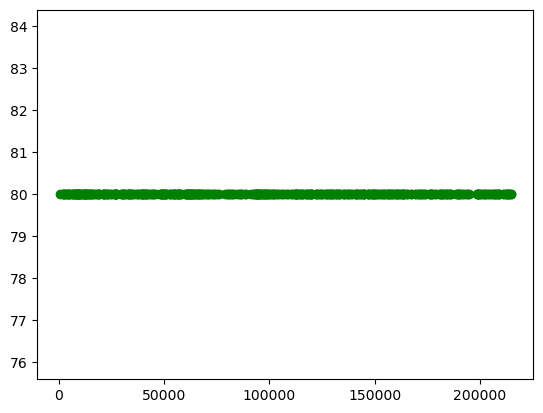

In [18]:
Me = my_find_interaction_events(Dataset, Thresh=80, min_time=60, plot_signals=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


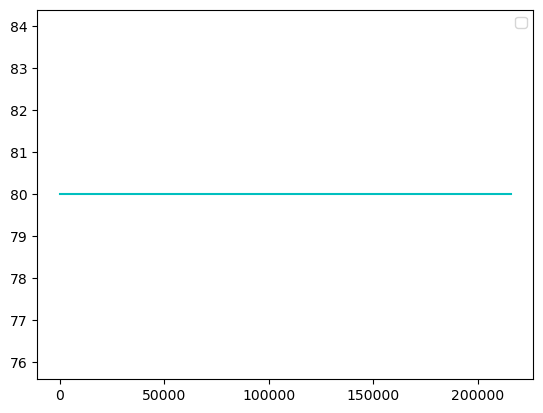

IndexError: tuple index out of range

In [12]:
find_interaction_events(Dataset, Thresh=80, min_time=60, plot_signals=True)

In [15]:
Dist = Dataset.loc[:, "yfly_smooth"] - Dataset.loc[:, "yball_smooth"]

In [16]:
Dist

0         152.473327
1         152.530480
2         152.587633
3         152.644786
4         152.701939
             ...    
215995     12.313850
215996     10.882356
215997      9.450863
215998      8.019369
215999      6.587876
Length: 216000, dtype: float64

[215999   1831   2315   2704   4075   4815   5011   6306   7021   7539
   7987   8350   8588   8914   9259   9921  10223  11131  12049  12490
  12650  12866  13781  14371  14880  15735  16337  17445  18803  19168
  21166  21561  22443  23159  24714  26244  26590  26947  27307  29495
  30178  31100  31529  32941  33457  33945  34813  36180  37718  38839
  39417  40128  40662  41301  41873  43191  43577  44575  45034  47887
  48355  48852  49565  49950  50354  50854  52661  53305  54020  54535
  54834  55926  56719  57027  58033  59878  60495  61052  61538  62128
  62452  63040  63410  64182  64754  65621  66168  66660  67290  68367
  69884  71047  72302  73534  75282  79099  80498  81191  82414  84392
  85402  85874  86801  87336  89054  92049  92917  93719  94077  94619
  95069  95388  96162  96829  97385  97722  98527  99032  99731 100701
 101825 102675 104098 106070 107443 107971 108950 110837 112059 112714
 113079 113423 114559 115528 115633 116258 116838 117702 118113 119030
 11987

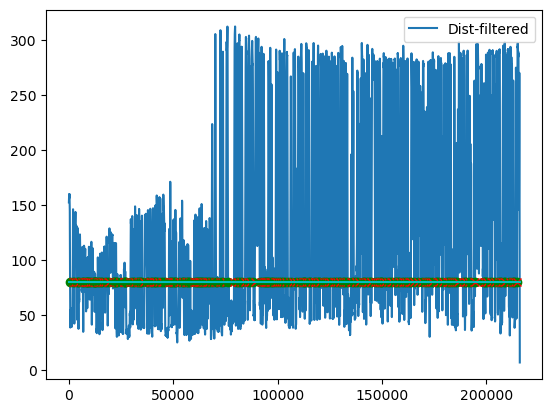

In [19]:
VLR = find_events_from(Dist, [0, 80], 1, 60, plot_signals=True, signal_name="Dist")

In [20]:
VLR

[[565, 1831, 1266],
 [2145, 2315, 170],
 [2505, 2704, 199],
 [3878, 4075, 197],
 [4378, 4815, 437],
 [4833, 5011, 178],
 [6072, 6306, 234],
 [6690, 7021, 331],
 [7384, 7539, 155],
 [8034, 8350, 316],
 [8437, 8588, 151],
 [8726, 8914, 188],
 [9099, 9259, 160],
 [9721, 9921, 200],
 [10031, 10223, 192],
 [10867, 11131, 264],
 [11788, 12049, 261],
 [12171, 12490, 319],
 [12579, 12650, 71],
 [12733, 12866, 133],
 [12880, 13781, 901],
 [13943, 14371, 428],
 [14437, 14880, 443],
 [15213, 15735, 522],
 [15922, 16337, 415],
 [17227, 17445, 218],
 [18424, 18803, 379],
 [18986, 19168, 182],
 [21074, 21166, 92],
 [21479, 21561, 82],
 [22154, 22443, 289],
 [22707, 23159, 452],
 [23274, 24714, 1440],
 [24836, 26244, 1408],
 [26455, 26590, 135],
 [26735, 26947, 212],
 [27038, 27307, 269],
 [27348, 29495, 2147],
 [29930, 30178, 248],
 [30483, 31100, 617],
 [31370, 31529, 159],
 [32640, 32941, 301],
 [33230, 33457, 227],
 [33827, 33945, 118],
 [34208, 34813, 605],
 [35111, 36180, 1069],
 [37323, 37718,

In [22]:
len(VLR)

216

In [21]:
Me

[(566, 1832),
 (2146, 2316),
 (2506, 2705),
 (3879, 4076),
 (4379, 4816),
 (4834, 5012),
 (6073, 6307),
 (6691, 7022),
 (7385, 7540),
 (8035, 8351),
 (8438, 8589),
 (8727, 8915),
 (9100, 9260),
 (9722, 9922),
 (10032, 10224),
 (10868, 11132),
 (11789, 12050),
 (12172, 12491),
 (12580, 12651),
 (12734, 12867),
 (12881, 13782),
 (13944, 14372),
 (14438, 14881),
 (15214, 15736),
 (15923, 16338),
 (17228, 17446),
 (18425, 18804),
 (18987, 19169),
 (21075, 21167),
 (21480, 21562),
 (22155, 22444),
 (22708, 23160),
 (23275, 24715),
 (24837, 26245),
 (26456, 26591),
 (26736, 26948),
 (27039, 27308),
 (27349, 29496),
 (29931, 30179),
 (30484, 31101),
 (31371, 31530),
 (32641, 32942),
 (33231, 33458),
 (33828, 33946),
 (34209, 34814),
 (35112, 36181),
 (37324, 37719),
 (38041, 38840),
 (39270, 39418),
 (39617, 40129),
 (40554, 40663),
 (41022, 41302),
 (41624, 41874),
 (42534, 43192),
 (43934, 44576),
 (44888, 45035),
 (46017, 47888),
 (48139, 48356),
 (48760, 48853),
 (49074, 49566),
 (49756, 

In [23]:
len(Me)

216

[215999   1831   2315   2704   4075   4815   5011   6306   7021   7539
   7987   8350   8588   8914   9259   9921  10223  11131  12049  12490
  12650  12866  13781  14371  14880  15735  16337  17445  18803  19168
  21166  21561  22443  23159  24714  26244  26590  26947  27307  29495
  30178  31100  31529  32941  33457  33945  34813  36180  37718  38839
  39417  40128  40662  41301  41873  43191  43577  44575  45034  47887
  48355  48852  49565  49950  50354  50854  52661  53305  54020  54535
  54834  55926  56719  57027  58033  59878  60495  61052  61538  62128
  62452  63040  63410  64182  64754  65621  66168  66660  67290  68367
  69884  71047  72302  73534  75282  79099  80498  81191  82414  84392
  85402  85874  86801  87336  89054  92049  92917  93719  94077  94619
  95069  95388  96162  96829  97385  97722  98527  99032  99731 100701
 101825 102675 104098 106070 107443 107971 108950 110837 112059 112714
 113079 113423 114559 115528 115633 116258 116838 117702 118113 119030
 11987

TypeError: float() argument must be a string or a real number, not 'module'

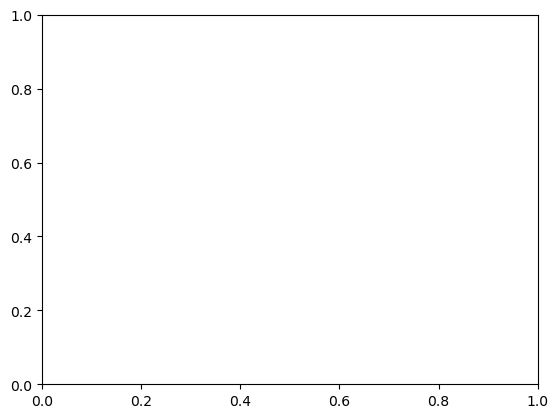

In [26]:
New = find_interaction_events(Dataset, thresh=[0, 80], min_length=60, gap_between_events=1, plot_signals=True, omit_events=None, signal_name="Dist")